In [9]:
import time
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

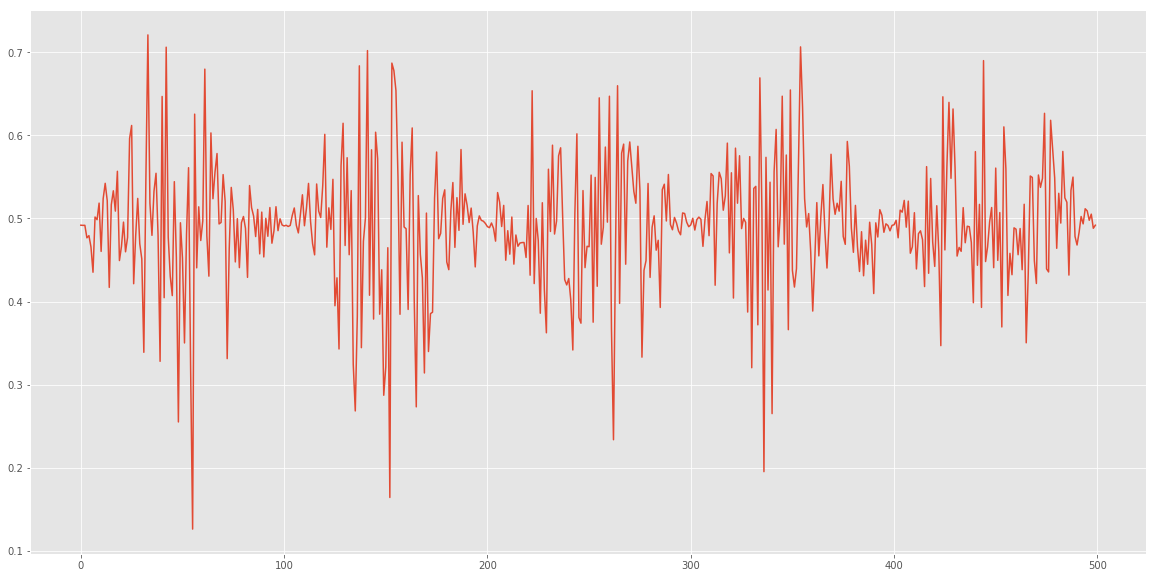

In [10]:
# n = 60
# ts_len = 80

n = 10000
ts_len = 500


phases = np.array(np.random.randint(0, 50, [n, 2]))
pure = np.sin([np.linspace(-np.pi * x[0], -np.pi * x[1], ts_len) for x in phases])
noise = np.array([np.random.normal(0, 1, ts_len) for x in range(n)])
signals = pure * noise
# Normalize everything between 0 and 1
signals += np.abs(np.min(signals))
signals /= np.max(signals)
plt.plot(signals[0])

In [13]:
# MSE - mean squared error
def euclid_dist(t1, t2):
    return np.sqrt(((t1-t2)**2).sum(axis = 1))

def calc_centroids(data, centroids):
    dist = np.zeros([data.shape[0], centroids.shape[0]])
    for idx, centroid in enumerate(centroids): 
        dist[:, idx] = euclid_dist(centroid, data)
    return np.array(dist)
def closest_centroids(data, centroids): 
    dist = calc_centroids(data, centroids) 
    return np.argmin(dist, axis = 1)
def move_centroids(data, closest, centroids):
    k = centroids.shape[0]
    new_centroids = np.array([data[closest == c].mean(axis = 0) for c in np.unique(closest)])
    if k - new_centroids.shape[0] > 0:
       print("adding {} centroid(s)".format(k - new_centroids.shape[0]))
       additional_centroids = data[np.random.randint(0, data.shape[0], k - new_centroids.shape[0])] 
       new_centroids = np.append(new_centroids, additional_centroids, axis = 0)
    return new_centroids

def k_means(data, num_clust, num_iter):
    # signals.shape[0] = 10,000 same as n
    centroids = signals[np.random.randint(0, signals.shape[0], num_clust)]
    last_centroids = centroids
    for n in range(num_iter):
        closest = closest_centroids(data, centroids)
        centroids = move_centroids(data, closest, centroids)
        if not np.any(last_centroids != centroids):
           print("early finish!")
           break
        last_centroids = centroids 
        
    return centroids


In [14]:
t1 = time.time()
centroids = k_means(signals, 100, 100)
t2 = time.time()
print("Took {} seconds".format(t2 - t1))

10000
adding 1 centroid(s)


KeyboardInterrupt: 

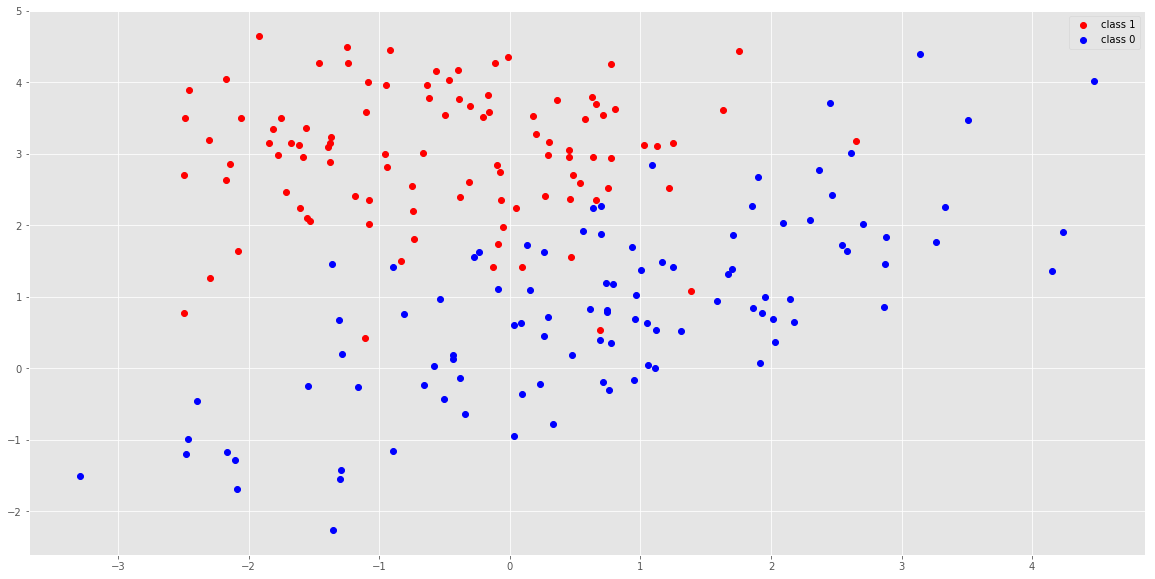

In [2]:
num_points_each_cluster = 100
mu1 = [-0.4, 3]
covar1 = [[1.3,0],[0,1]]
mu2 = [0.5, 0.75]
covar2 = [[2.2,1.2],[1.8,2.1]]
X1 = np.random.multivariate_normal(mu1, covar1, num_points_each_cluster)
X2 = np.random.multivariate_normal(mu2, covar2, num_points_each_cluster)
y1 = np.ones(num_points_each_cluster)
y2 = np.zeros(num_points_each_cluster)

plt.plot( X1[:, 0], X1[:,1], 'ro', label='class 1')
plt.plot(X2[:, 0], X2[:,1], 'bo', label='class 0')
plt.legend(loc='best')
plt.show()

/Users/stephanieliu/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


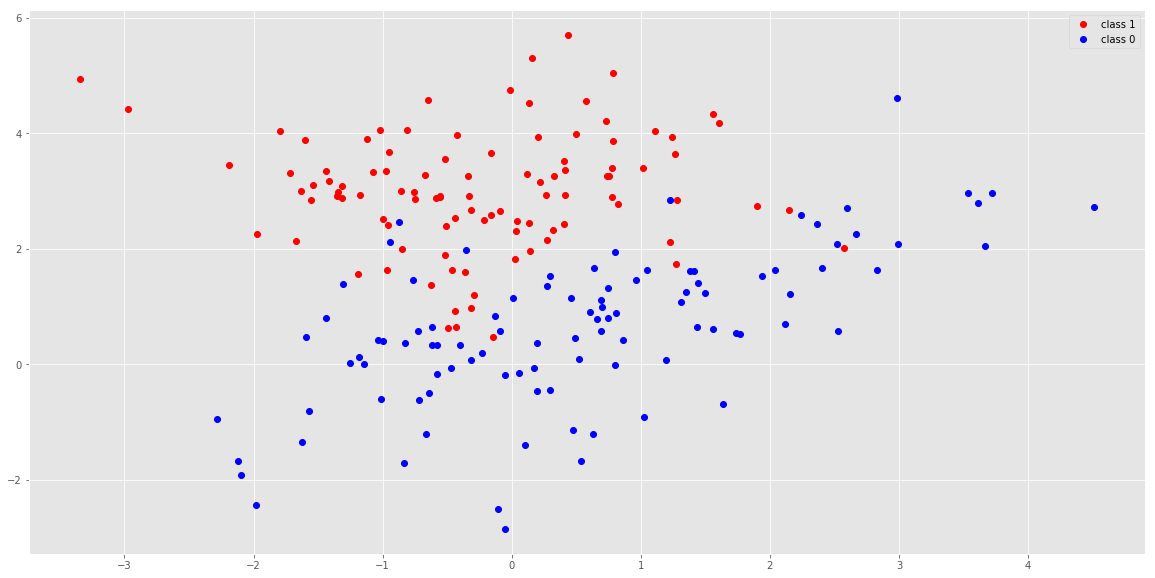

In [1]:
# X = np.vstack((X1, X2))
# y = np.hstack((y1, y2))
# print X.shape, y.shape

# (200, 2) (200,)
# X_tf = tf.constant(X)
# y_tf = tf.constant(y)

# def predict(X_t, y_t, x_t, k_t):
#     neg_one = tf.constant(-1.0, dtype=tf.float64)
#     # we compute the L-1 distance
#     distances =  tf.reduce_sum(tf.abs(tf.subtract(X_t, x_t)), 1)
#     # to find the nearest points, we find the farthest points based on negative distances
#     # we need this trick because tensorflow has top_k api and no closest_k or reverse=True api
#     neg_distances = tf.multiply(distances, neg_one)
#     # get the indices
#     vals, indx = tf.nn.top_k(neg_distances, k_t)
#     # slice the labels of these points
#     y_s = tf.gather(y_t, indx)
#     return y_s
    
    
# def get_label(preds):
#     counts = np.bincount(preds.astype('int64'))
#     return np.argmax(counts)

# example = np.array([0, 0])
# example_tf = tf.constant(example,dtype=tf.float64)

# plt.plot( X1[:, 0], X1[:,1], 'ro', label='class 1')
# plt.plot(X2[:, 0], X2[:,1], 'bo', label='class 0')
# plt.plot(example[0], example[1], 'g', marker='D', markersize=10, label='test point')
# plt.legend(loc='best')
# plt.show()

# k_tf = tf.constant(3)
# pr = predict(X_tf, y_tf, example_tf, k_tf)
# sess = tf.Session()
# y_index = sess.run(pr)
# print get_label(y_index)
# 0
# example_2 = np.array([0.1, 2.5])
# example_2_tf = tf.constant(example_2)
# plt.plot( X1[:, 0], X1[:,1], 'ro', label='class 1')
# plt.plot(X2[:, 0], X2[:,1], 'bo', label='class 0')
# plt.plot(example_2[0], example_2[1], 'g', marker='D', markersize=10, label='test point')
# plt.legend(loc='best')
# plt.show()

# pr = predict(X_tf, y_tf, example_2_tf, k_tf)
# y_index = sess.run(pr)
# print get_label(y_index)